In [1]:
# ref: 

# https://alexioannides.com/2018/11/07/bayesian-regression-in-pymc3-using-mcmc-variational-inference/
# https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html

# http://stronginference.com/pymc3-release.html
# https://docs.pymc.io/notebooks/getting_started.html

# https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501

In [2]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
np.random.seed(14)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
''' function definitions '''
# true low-fidelity and true high-fidelity models
f_l = lambda x: (0.5*(6*x-2)**2*np.sin(12*x-4))+(10*(x-0.5))+(-5)
f_h = lambda x: ((6*x-2)**2*np.sin(12*x-4))

In [4]:
N_l = 11 # number of low fidelity data observations
N_h = 4 # number of high fidelity data observations

# [X_l,Y_l] and [X_h,Y_h] are low are high fidelity data respectively.
X_l = np.linspace(0.0, 1.0, N_l)[:, None]

# # for not-nested data
# X_h = np.random.rand(N_h, 1)

# # for nested data
perm = np.random.permutation(N_l)
X_h = X_l[perm[0:N_h]]

Y_l = f_l(X_l)
Y_h = f_h(X_h)

print (X_l.shape, Y_l.shape)
print (X_h.shape, Y_h.shape)

(11, 1) (11, 1)
(4, 1) (4, 1)


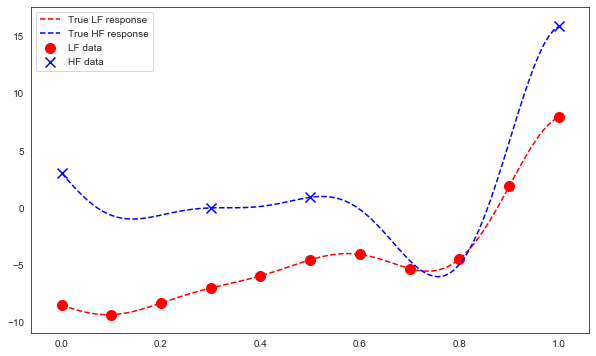

In [5]:
# just to show the plot
X_p = np.linspace(0.0, 1.0, 100)[:, None]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(X_p, f_l(X_p), 'r--', label='True LF response')
ax.scatter(X_l, Y_l, color='red', marker='o', s=100, label='LF data')
ax.plot(X_p, f_h(X_p), 'b--', label='True HF response')
ax.scatter(X_h, Y_h, color='blue', marker='x', s=100, label='HF data')

ax.legend()
plt.show()

## Pymc model

In [6]:
# BNN parameters
H = 10
d = [X_l.shape[1], H, H, 2]  # num_neurons_per_layer
act_func = pm.math.tanh

In [7]:
# Initialize random weights and biases between each layer
init_Ws = []
init_bs = []
for i in range(len(d)-1):
    init_W = np.random.randn(d[i], d[i+1]).astype(floatX)
    init_b = np.random.randn(d[i+1]).astype(floatX)
    init_Ws.append(init_W)
    init_bs.append(init_b)
    
# DNN
def DNN(x_tensor, Ws, bs):
    h = act_func(pm.math.dot(x_tensor,Ws[0])+bs[0])
    for i in range(1,len(d)-2):
        h = act_func(pm.math.dot(h,Ws[i])+bs[i])
    act_out = pm.math.dot(h,Ws[-1])+bs[-1]
    return act_out
    
    
with pm.Model() as neural_network:
    # Trick: Turning inputs and outputs into shared variables 
    # It's still the same thing, but we can later change the values of the shared variable
    # (to switch in the test-data later) and pymc3 will just use the new data.
    # Kind-of like a pointer we can redirect.
    # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
    y_tensor_low = theano.shared(Y_l)
    x_tensor_low = theano.shared(X_l)
    
    y_tensor_high = theano.shared(Y_h)
    x_tensor_high = theano.shared(X_h)

    #PRIOR
    # Weights and biases 
    Ws = []
    bs = []
    for i in range(len(d)-1):
        W = pm.Normal('W_'+str(i), mu=0, sigma=1, shape=(d[i], d[i+1]), testval=init_Ws[i])
        b = pm.Normal('b_'+str(i), mu=0, sigma=1, shape=(d[i+1]), testval=init_bs[i])
        Ws.append(W)
        bs.append(b)
        
    # Build neural-network using activation function
    act_out_low = DNN(x_tensor_low, Ws, bs)[:,0][:,None]
    act_out_high = DNN(x_tensor_high, Ws, bs)[:,1][:,None]

    # LIKELIHOOD
    out1 = pm.Normal('out1', mu=act_out_low, sigma=0.01, observed=y_tensor_low)
    out2 = pm.Normal('out2', mu=act_out_high, sigma=0.01, observed=y_tensor_high)

## Checking prior draws

In [8]:
# Now we would like to make some predictions
# Namely, we wish to predict at this dense set of points:
X_p = np.linspace(0.0, 1.0, 100)[:, None]
print (X_p.shape)

(100, 1)


(10, 100, 2)
(10, 100)
(10, 100)


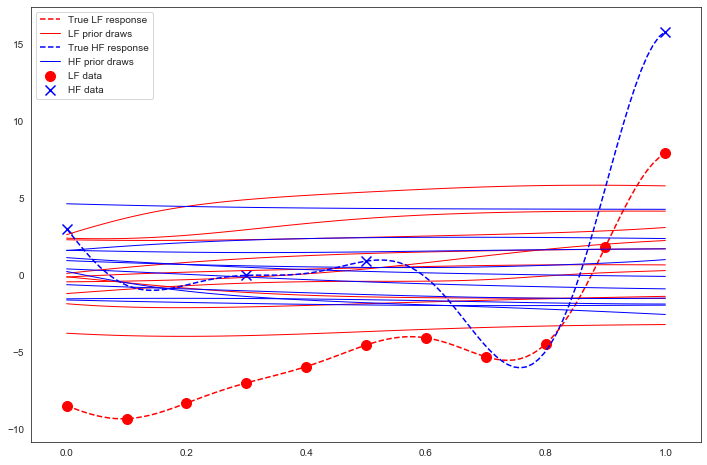

In [9]:
with neural_network:
    n_plot = 10 # number of prediction samples to plot
    
    def prior_sampler():
        Ws_p = []
        bs_p = []
        for i in range(len(d)-1):
            W_p = Ws[i].random()
            b_p = bs[i].random()
            Ws_p.append(W_p)
            bs_p.append(b_p)
        return Ws_p, bs_p
    
    preds = []
    for j in range(n_plot):
        Ws_p, bs_p = prior_sampler()
        pred = DNN( X_p, Ws_p , bs_p )
        preds. append (pred)

    preds = [preds[j].eval() for j in range(len(preds))]
    preds = np.asarray(preds)

    outputs_low = preds[:,:,0]
    outputs_high = preds[:,:,1]

    print(np.shape(preds))
    print(np.shape(outputs_low))
    print(np.shape(outputs_high))

    #########
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    ax.plot(X_p, f_l(X_p), 'r--', label='True LF response')
    ax.scatter(X_l, Y_l, color='red', marker='o', s=100, label='LF data')
    ax.plot(X_p,outputs_low[0].T, lw=1, label='LF prior draws', color='red')
    ax.plot(X_p,outputs_low[1:n_plot].T, lw=1, color='red')

    ax.plot(X_p, f_h(X_p), 'b--', label='True HF response')
    ax.scatter(X_h, Y_h, color='blue', marker='x', s=100, label='HF data')
    ax.plot(X_p,outputs_high[0].T, lw=1, label='HF prior draws',color='blue')
    ax.plot(X_p,outputs_high[1:n_plot].T, lw=1, color='blue')

    ax.legend()
    plt.show()
    #########

In [10]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

## ADVI

In [11]:
# Carrying out ADVI

with neural_network:
#     advi_fit = pm.fit(n=80000, method=pm.ADVI())
    advi_fit = pm.fit(n=80000, method=pm.ADVI(), obj_optimizer = pm.adam())

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 4,554.6: 100%|██████████| 80000/80000 [01:38<00:00, 811.26it/s]    
Finished [100%]: Average Loss = 4,554.2


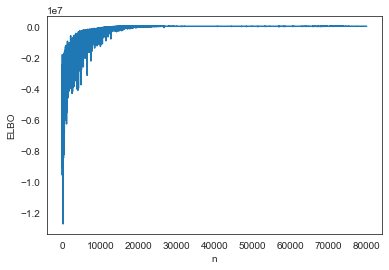

In [12]:
advi_elbo = pd.DataFrame(
    {'ELBO': -(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

## Drawing samples

In [13]:
trace = advi_fit.sample(draws=10000)

In [14]:
print(trace.get_values('W_0').shape)
print(trace['W_0'].shape)

(10000, 1, 10)
(10000, 1, 10)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12630da20>,
      dtype=object)

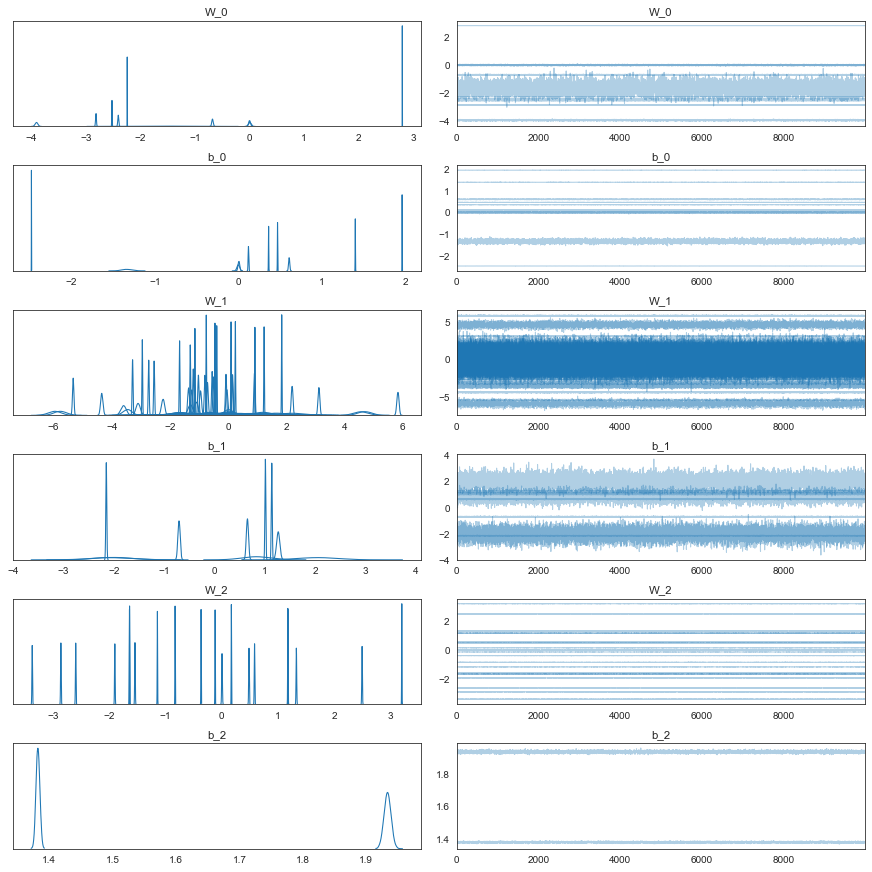

In [15]:
pm.traceplot(trace)
# pm.summary(trace)
# pm.forestplot(trace)

## Checking posterior draws

(10, 100, 2)
(10, 100)
(10, 100)


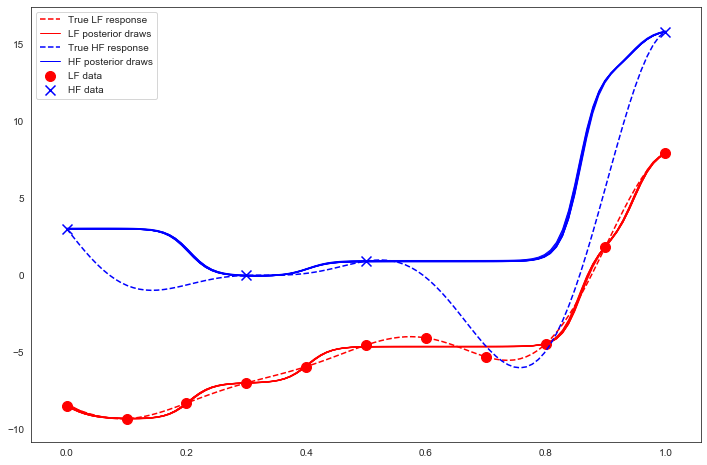

In [16]:
n_plot = 10 # number of prediction samples to plot

def posterior_sampler(j):
    Ws_post = []
    bs_post = []
    for i in range(len(d)-1):
        W_post = trace['W_'+str(i)][ j ]
        b_post = trace['b_'+str(i)][ j ]
        Ws_post.append(W_post)
        bs_post.append(b_post)
    return Ws_post, bs_post

preds = []
for j in range(n_plot):
    Ws_post, bs_post = posterior_sampler(j)
    pred = DNN( X_p, Ws_post, bs_post )
    preds. append (pred)

preds = [preds[j].eval() for j in range(len(preds))]
preds = np.asarray(preds)

outputs_low = preds[:,:,0]
outputs_high = preds[:,:,1]

print(np.shape(preds))
print(np.shape(outputs_low))
print(np.shape(outputs_high))

#########
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

ax.plot(X_p, f_l(X_p), 'r--', label='True LF response')
ax.scatter(X_l, Y_l, color='red', marker='o', s=100, label='LF data')
ax.plot(X_p,outputs_low[0].T, lw=1, label='LF posterior draws', color='red')
ax.plot(X_p,outputs_low[1:n_plot].T, lw=1, color='red')

ax.plot(X_p, f_h(X_p), 'b--', label='True HF response')
ax.scatter(X_h, Y_h, color='blue', marker='x', s=100, label='HF data')
ax.plot(X_p,outputs_high[0].T, lw=1, label='HF posterior draws',color='blue')
ax.plot(X_p,outputs_high[1:n_plot].T, lw=1, color='blue')

ax.legend()
plt.show()

(200, 100, 2)
(200, 100)
(200, 100)


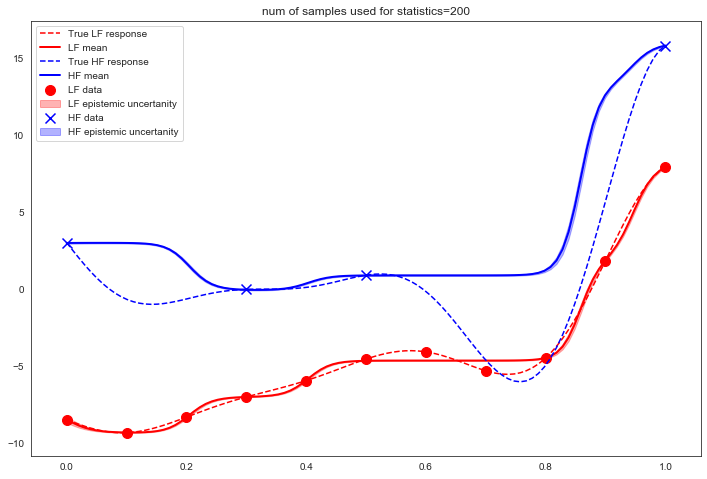

In [17]:
n_stat = 200 # number of prediction samples to calculate statistics

preds = []
for j in range(n_stat):
    Ws_post, bs_post = posterior_sampler(j)
    pred = DNN( X_p, Ws_post, bs_post )
    preds. append (pred)

preds = [preds[j].eval() for j in range(len(preds))]
preds = np.asarray(preds)

outputs_low = preds[:,:,0]
outputs_high = preds[:,:,1]

print(np.shape(preds))
print(np.shape(outputs_low))
print(np.shape(outputs_high))

#########
mean_outputs_low = np.mean(outputs_low, axis=0)
stddev_outputs_low = np.std(outputs_low, axis=0)
mean_outputs_high = np.mean(outputs_high, axis=0)
stddev_outputs_high = np.std(outputs_high, axis=0)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

ax.plot(X_p, f_l(X_p), 'r--', label='True LF response')
ax.scatter(X_l, Y_l, color='red', marker='o', s=100, label='LF data')
ax.plot(X_p, mean_outputs_low ,lw=2, label='LF mean', color='red')
ax.fill_between(X_p.ravel(), (mean_outputs_low-1.96*stddev_outputs_low).ravel(), (mean_outputs_low+1.96*stddev_outputs_low).ravel(), alpha = 0.3, color = 'red',label='LF epistemic uncertanity')

ax.plot(X_p, f_h(X_p), 'b--', label='True HF response')
ax.scatter(X_h, Y_h, color='blue', marker='x', s=100, label='HF data')
ax.plot(X_p, mean_outputs_high ,lw=2, label='HF mean', color='blue')
ax.fill_between(X_p.ravel(), (mean_outputs_high-1.96*stddev_outputs_high).ravel(), (mean_outputs_high+1.96*stddev_outputs_high).ravel(), alpha = 0.3, color = 'blue',label='HF epistemic uncertanity')

plt.title('num of samples used for statistics='+str(n_stat))

ax.legend()
plt.show()